# Clean, Combine, and Transform Dataset (Toronto, Barcelona, Rome) - Kunyan

In [1]:
!pip install vaderSentiment
!pip install wordcloud
!pip install lightgbm
!pip install imblearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 1.6 MB/s eta 0:00:00


In [2]:
!pip install pandas
!pip install numpy
!pip install matplotlib.pyplot
!pip install seaborn

ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot


In [3]:
# Statistical packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Text
import re
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud,STOPWORDS

plt.rc('figure',figsize=(8,7.5))

np.random.seed(1)

Combining three datasets of the target cities: Rome, Toronto. Barcelona

In [ ]:
df_sydney = pd.read_csv('/content/reviews_Sydney.csv')
df_toronto = pd.read_csv('/content/reviews_Toronto.csv')
df_barcelona = pd.read_csv('/content/reviews_Barcelona.csv')
combined_df = pd.concat([df_barcelona, df_sydney, df_toronto])
combined_df.to_csv('combined_reviews.csv', index=False)

In [ ]:
# data cleaning
def clean_content(x:str):
    x=x.lower()

    x = re.sub('\[.*?\]', '', x)
    x = re.sub('<.*?>+', '', x)

    x = re.sub('https?://\S+|www\.\S+', '', x)

    x = re.sub('[%s]' % re.escape(string.punctuation), '', x)
    x = re.sub('\n', '', x)

    x = re.sub('\w*\d\w*', '', x)
    return x

In [ ]:
data_review = pd.read_csv('/content/combined_reviews.csv')
data_review.head()

<ipython-input-34-635abb425f02>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data_review = pd.read_csv('/content/combined_reviews.csv')


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,17475,63134.0,2010-07-10,141807.0,Zoltan,"Excellent host, beautiful apartment, great loc..."
1,17475,83802.0,2010-08-24,68687.0,John,"Luca is very personable, and the views are exa..."
2,17475,98998.0,2010-09-17,96055.0,Xiaoyang,I am glad we found Luca's apt for our stay in ...
3,17475,105280.0,2010-09-26,171084.0,Amy,I should start by saying we really did not wan...
4,17475,109755.0,2010-10-02,31238.0,Mike,Luca was a very gracious host and took efforts...


In [ ]:
data_review['comments'] = data_review['comments'].astype(str).apply(clean_content)

In [ ]:
# I combined the data but I find that many rows of review directing to the same listing id, so I want to sample the top 10 review texts for each listing id
top_reviews_df = data_review.groupby('listing_id').head(10)

In [ ]:
top_reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,17475,63134.0,2010-07-10,141807.0,Zoltan,excellent host beautiful apartment great locat...
1,17475,83802.0,2010-08-24,68687.0,John,luca is very personable and the views are exac...
2,17475,98998.0,2010-09-17,96055.0,Xiaoyang,i am glad we found lucas apt for our stay in b...
3,17475,105280.0,2010-09-26,171084.0,Amy,i should start by saying we really did not wan...
4,17475,109755.0,2010-10-02,31238.0,Mike,luca was a very gracious host and took efforts...


Sentiment Analysis to convert all text data into sentiment polarity score

In [ ]:
analyzer = SentimentIntensityAnalyzer()

def compound_score(txt):
    return analyzer.polarity_scores(txt)["compound"]

def sentiment(score):
    emotion = ""
    if score >= 0.5:
        emotion = "Positive"
    elif score <= -0.5:
        emotion = "Negative"
    else:
        emotion = "Neutral"
    return emotion

In [ ]:
polarity_scores = top_reviews_df['comments'].astype('str').apply(compound_score)
top_reviews_df['Sentiment_Score'] = polarity_scores

<ipython-input-39-0030eb913421>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_reviews_df['Sentiment_Score'] = polarity_scores


Wordcloud Visualization

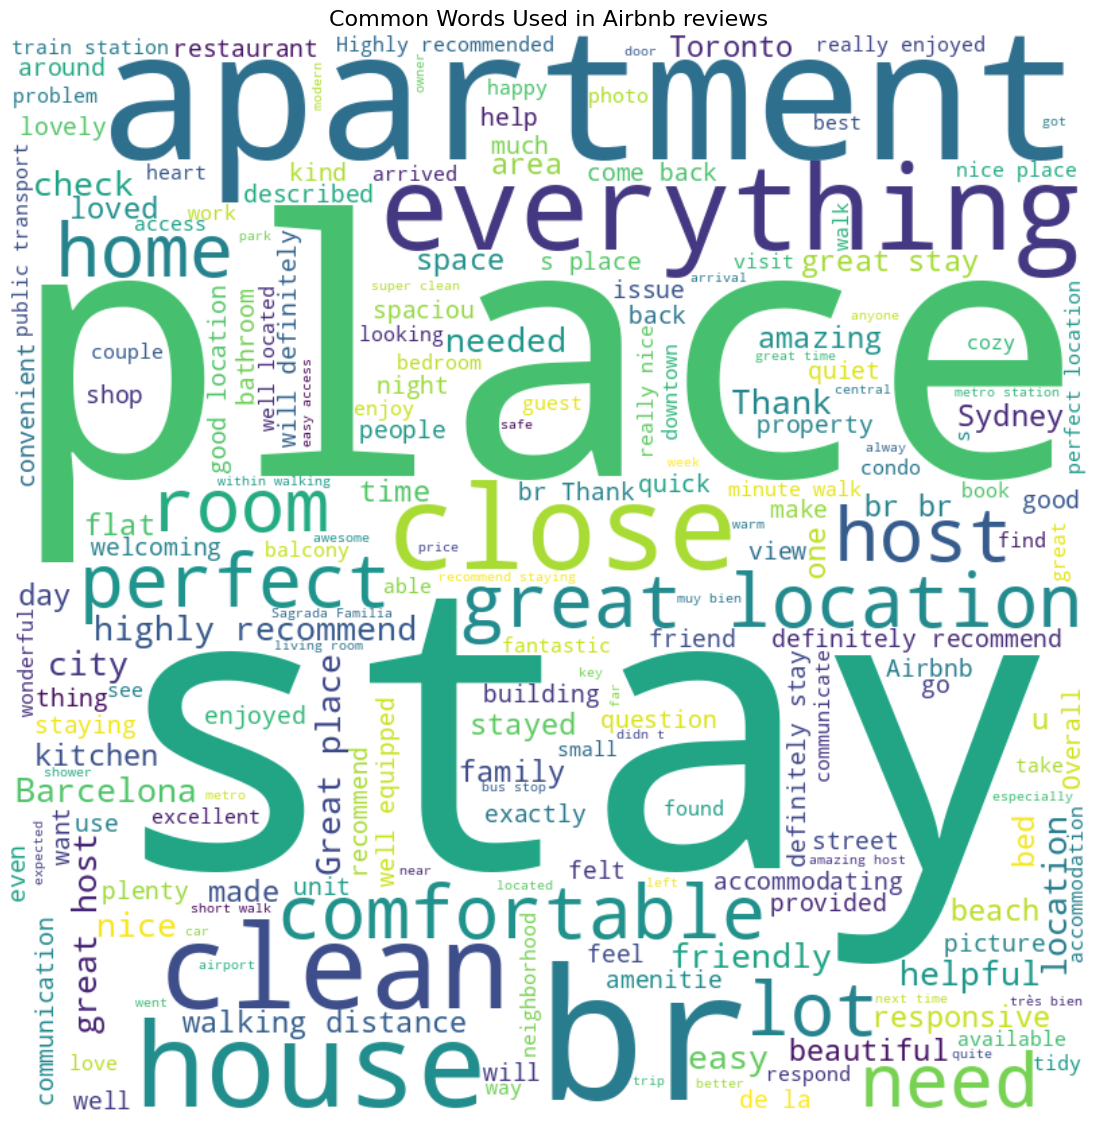

In [ ]:

np.array(list(STOPWORDS))[0:5]
fig, (ax1) = plt.subplots(1, figsize=[14, 14], facecolor = None)

wc = WordCloud(width = 800, height = 800,background_color="white",min_font_size = 10,\
    repeat=True,stopwords = STOPWORDS)
wc.generate("".join(top_reviews_df['comments'].astype(str)))
ax1.axis("off")
ax1.imshow(wc, interpolation="bilinear")
ax1.set_title('Common Words Used in Airbnb reviews',fontsize=16);

Replace the text data with Sentiment Score

In [ ]:
top_reviews_df["Sentiment"] = top_reviews_df["Sentiment_Score"].apply(sentiment)

# Calculate the mean sentiment polarity for each listing_id
mean_sentiment = top_reviews_df.groupby('listing_id')['Sentiment_Score'].mean().rename('mean_sentiment').reset_index()

# Merge the mean sentiment scores back into the original DataFrame
top_reviews_df = pd.merge(top_reviews_df, mean_sentiment, on='listing_id')

# Drop the review text column
top_reviews_df = top_reviews_df.drop(columns=['comments'])

# Save the updated DataFrame to a new CSV file
top_reviews_df.to_csv('updated_combined_reviews.csv', index=False)


<ipython-input-40-62ef78922791>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_reviews_df["Sentiment"] = top_reviews_df["Sentiment_Score"].apply(sentiment)


Combining the review datasets with the listings dataset

In [ ]:
top_reviews_df.columns.tolist()

['listing_id',
 'id',
 'date',
 'reviewer_id',
 'reviewer_name',
 'Sentiment_Score',
 'Sentiment',
 'mean_sentiment']

In [ ]:
columns_to_drop = ['id', 'date', 'reviewer_id', 'reviewer_name', 'Sentiment_Score', 'Sentiment']
top_reviews_df = top_reviews_df.drop(columns=columns_to_drop)

top_reviews_df = top_reviews_df.drop_duplicates(subset=['listing_id'])

In [ ]:
top_reviews_df = top_reviews_df[top_reviews_df['mean_sentiment'] != 0]

print(top_reviews_df)

                 listing_id  mean_sentiment
0                     17475        0.789280
10                    18674        0.595350
20                    23197        0.753830
41                    32711        0.521860
51                    34241        0.765075
...                     ...             ...
340372  1052319083870161124        0.624900
340373  1057929286925165858        0.571900
340374  1053010334213066893        0.177900
340375  1061704502413506115        0.894700
340376  1053372809437539904        0.895700

[46553 rows x 2 columns]


In [ ]:
top_reviews_df.to_csv('updated_combined_reviews.csv', index=False)


Combining the listings datasets with the sentiment scores

In [ ]:
df_sydney = pd.read_csv('/content/listings_Sydney.csv')
df_toronto = pd.read_csv('/content/listings_Toronto.csv')
df_barcelona = pd.read_csv('/content/listings_Barcelona.csv')
data_listing = pd.concat([df_barcelona, df_sydney, df_toronto])

In [ ]:
data_listing.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,17475,https://www.airbnb.com/rooms/17475,20231213195414,2023-12-14,city scrape,Rental unit in 08013 Barcelona · ★4.40 · 1 bed...,NaN,NaN,https://a0.muscache.com/pictures/f6e6718f-dba0...,65623,...,4.68,4.84,4.47,NaN,f,1,1,0,0,0.16
1,18674,https://www.airbnb.com/rooms/18674,20231213195414,2023-12-14,city scrape,Rental unit in Barcelona · ★4.33 · 3 bedrooms ...,NaN,Apartment in Barcelona located in the heart of...,https://a0.muscache.com/pictures/13031453/413c...,71615,...,4.67,4.77,4.28,HUTB-002062,t,30,30,0,0,0.31
2,198958,https://www.airbnb.com/rooms/198958,20231213195414,2023-12-14,city scrape,Rental unit in Barcelona · ★4.69 · 4 bedrooms ...,NaN,"The Illa del Llac complex is a calm, relaxing ...",https://a0.muscache.com/pictures/2977a5e1-e7e4...,971768,...,4.87,4.80,4.67,HUTB-000926,f,9,9,0,0,0.74
3,199794,https://www.airbnb.com/rooms/199794,20231213195414,2023-12-14,city scrape,Rental unit in Barcelona · ★4.80 · 1 bedroom ·...,NaN,The apartment is located in a very safe area a...,https://a0.muscache.com/pictures/21904425/cbb2...,440825,...,4.92,4.89,4.80,Exempt,f,1,0,1,0,1.34
4,23197,https://www.airbnb.com/rooms/23197,20231213195414,2023-12-14,city scrape,Rental unit in Sant Adria de Besos · ★4.77 · 3...,NaN,"Strategically located in the Parc del Fòrum, a...",https://a0.muscache.com/pictures/miso/Hosting-...,90417,...,4.97,4.59,4.64,HUTB005057,f,2,2,0,0,0.48


In [ ]:
# remove insignificant columns
columns_to_drop = [ 'picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified', 'license', 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'calendar_updated', 'license',
 'instant_bookable', 'calculated_host_listings_count',
 'calculated_host_listings_count_entire_homes',
 'calculated_host_listings_count_private_rooms',
 'calculated_host_listings_count_shared_rooms',]

data_listing = data_listing.drop(columns=columns_to_drop)


In [ ]:
data_listing.columns.tolist()

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'source',
 'name',
 'description',
 'neighborhood_overview',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'calendar_last_scraped',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'first_review',
 'last_review',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month']

In [ ]:
# continue cleaning the data
columns_to_drop = [ 'first_review',
 'last_review', 'first_review',
 'last_review', 'calendar_last_scraped','description',]

data_listing = data_listing.drop(columns=columns_to_drop)

data_listing.head()

,id,listing_url,scrape_id,last_scraped,source,name,neighborhood_overview,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,...,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,17475,https://www.airbnb.com/rooms/17475,20231213195414,2023-12-14,city scrape,Rental unit in 08013 Barcelona · ★4.40 · 1 bed...,NaN,NaN,la Dreta de l'Eixample,Eixample,...,9,1,4.40,4.74,4.21,4.79,4.68,4.84,4.47,0.16
1,18674,https://www.airbnb.com/rooms/18674,20231213195414,2023-12-14,city scrape,Rental unit in Barcelona · ★4.33 · 3 bedrooms ...,Apartment in Barcelona located in the heart of...,"Barcelona, CT, Spain",la Sagrada Família,Eixample,...,7,0,4.33,4.44,4.62,4.74,4.67,4.77,4.28,0.31
2,198958,https://www.airbnb.com/rooms/198958,20231213195414,2023-12-14,city scrape,Rental unit in Barcelona · ★4.69 · 4 bedrooms ...,"The Illa del Llac complex is a calm, relaxing ...","Barcelona, Spain",Diagonal Mar i el Front Marítim del Poblenou,Sant Martí,...,26,0,4.69,4.85,4.54,4.77,4.87,4.80,4.67,0.74
3,199794,https://www.airbnb.com/rooms/199794,20231213195414,2023-12-14,city scrape,Rental unit in Barcelona · ★4.80 · 1 bedroom ·...,The apartment is located in a very safe area a...,"Barcelona, Catalonia, Spain",l'Antiga Esquerra de l'Eixample,Eixample,...,29,1,4.80,4.82,4.79,4.94,4.92,4.89,4.80,1.34
4,23197,https://www.airbnb.com/rooms/23197,20231213195414,2023-12-14,city scrape,Rental unit in Sant Adria de Besos · ★4.77 · 3...,"Strategically located in the Parc del Fòrum, a...","Sant Adria de Besos, Barcelona, Spain",el Besòs i el Maresme,Sant Martí,...,11,1,4.77,4.92,4.88,4.93,4.97,4.59,4.64,0.48


In [ ]:
data_listing.columns.tolist()

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'source',
 'name',
 'neighborhood_overview',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month']

In [ ]:
# the fancy overview overlaps the neighborhood
columns_to_drop = [ 'scrape_id','source',
 'name',
 'listing_url', 'neighborhood_overview', 'amenities']

data_listing = data_listing.drop(columns=columns_to_drop)

data_listing.head()

,id,last_scraped,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,...,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,17475,2023-12-14,NaN,la Dreta de l'Eixample,Eixample,41.399390,2.17044,Entire rental unit,Entire home/apt,3,...,9,1,4.40,4.74,4.21,4.79,4.68,4.84,4.47,0.16
1,18674,2023-12-14,"Barcelona, CT, Spain",la Sagrada Família,Eixample,41.405560,2.17262,Entire rental unit,Entire home/apt,8,...,7,0,4.33,4.44,4.62,4.74,4.67,4.77,4.28,0.31
2,198958,2023-12-14,"Barcelona, Spain",Diagonal Mar i el Front Marítim del Poblenou,Sant Martí,41.408050,2.21487,Entire rental unit,Entire home/apt,7,...,26,0,4.69,4.85,4.54,4.77,4.87,4.80,4.67,0.74
3,199794,2023-12-14,"Barcelona, Catalonia, Spain",l'Antiga Esquerra de l'Eixample,Eixample,41.383590,2.15812,Private room in rental unit,Private room,1,...,29,1,4.80,4.82,4.79,4.94,4.92,4.89,4.80,1.34
4,23197,2023-12-14,"Sant Adria de Besos, Barcelona, Spain",el Besòs i el Maresme,Sant Martí,41.412432,2.21975,Entire rental unit,Entire home/apt,5,...,11,1,4.77,4.92,4.88,4.93,4.97,4.59,4.64,0.48


In [ ]:
print(data_listing)

NameError: name 'data_listing' is not defined

In [ ]:
top_reviews_df = pd.read_csv('/content/updated_combined_reviews.csv')

In [ ]:
top_reviews_df = top_reviews_df.rename(columns={'listing_id': 'id'})

In [ ]:
combined_df = pd.merge(data_listing, top_reviews_df, on='id')


In [ ]:
print(combined_df)

                       id last_scraped                neighbourhood  \
0                24238187   2023-12-14             BARCELONA, Spain   
1                24238588   2023-12-14             BARCELONA, Spain   
2                24239102   2023-12-13  Barcelona, Catalunya, Spain   
3                24249840   2023-12-14         Barcelona, CT, Spain   
4                24257237   2023-12-13             Barcelona, Spain   
...                   ...          ...                          ...   
22300  934027064352384246   2024-01-09                          NaN   
22301            43740738   2024-01-09     Toronto, Ontario, Canada   
22302  955162189200947880   2024-01-09     Toronto, Ontario, Canada   
22303  894406870652307040   2024-01-09     Toronto, Ontario, Canada   
22304  616449374883279574   2024-01-09     Toronto, Ontario, Canada   

                      neighbourhood_cleansed neighbourhood_group_cleansed  \
0      Sant Pere, Santa Caterina i la Ribera                 Ciutat Ve

In [ ]:
airbnb_prepared = combined_df
airbnb_prepared.to_csv('airbnb_prepared.csv', index=False)

NameError: name 'combined_df' is not defined

In [ ]:
df = pd.read_csv('/content/airbnb_prepared.csv')

<ipython-input-8-4f8d4d65c276>:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/airbnb_prepared.csv')


In [ ]:
df.columns.tolist()

['id',
 'last_scraped',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'price',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'number_of_reviews_ltm',
 'number_of_reviews_l30d',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month',
 'mean_sentiment']

# Landmark Clusters Analysis
Stuart

In [ ]:
# Web scraping code (won't work in Colab)
# from selenium import webdriver
# from selenium.webdriver.common.by import By
# import datetime
# import time
# import re
# from geopy.geocoders import Nominatim


# # STEP 1: GET ATTRACTIONS

# # Load the website
# driver = webdriver.Chrome()

# rows = []

# # Iterate through the pages
# for i in range(0, 121, 30):
#     driver.get(f'https://www.tripadvisor.ca/Attractions-g187497-Activities-oa{i}-Barcelona_Catalonia.html')

#     name = driver.find_elements(By.XPATH, '//div[@class = "XfVdV o AIbhI"]')

#     num_reviews = driver.find_elements(By.XPATH, '//span[@class = "biGQs _P pZUbB osNWb"]')

#     names = [i.text[i.text.index(".") + 2:].replace(",", "") for i in name]
#     num_reviews = [int(i.text.replace(",", "")) for i in num_reviews]

#     rows += list(zip(names, num_reviews))

#     time.sleep(3)

# # Write to file
# with open("attractions-barcelona.csv", "w") as f:
#     f.write("Name,Num Reviews\n")
#     for row in rows:
#         f.write(f"{row[0]},{row[1]}\n")


# # STEP 2: GET COORDINATES

# geolocator = Nominatim(user_agent="CISC372-Project")

# # For each location, get the coordinates from geopy
# lines = []
# with open("attractions-barcelona.csv", "r") as f:
#     data = f.readlines()[1:]
#     data = [i.strip().split(",") for i in data]

#     for i in data:
#         if int(i[1]) < 1500:
#             continue
#         try:
#             location = i[0] + ", Barcelona, Spain"
#             address = geolocator.geocode(location)
#             print(address)
#             i.append(address.latitude)
#             i.append(address.longitude)
#             lines.append(i)
#             time.sleep(3)
#         except:
#             print(f"Failed to get location for {location}")

# # Write to file
# print(lines)
# with open("attractions-barcelona2.csv", "w") as f:
#     f.write("Name,Num Reviews,Latitude,Longitude\n")
#     for line in lines:
#         f.write(f"{line[0]},{int(line[1])},{float(line[2])},{float(line[3])}\n")

In [ ]:
# Create table with all landmarks
with open("attractions-toronto2.csv", "r") as f:
    data_toronto = f.readlines()[1:]
    data_toronto = [i.strip().split(",") for i in data_toronto]
    data_toronto = [["Toronto", i[0], int(i[1]), float(i[2]), float(i[3])] for i in data_toronto]

with open("attractions-barcelona2.csv", "r") as f:
    data_barcelona = f.readlines()[1:]
    data_barcelona = [i.strip().split(",") for i in data_barcelona]
    data_barcelona = [["Barcelona", i[0], int(i[1]), float(i[2]), float(i[3])] for i in data_barcelona]

with open("attractions-sydney2.csv", "r") as f:
    data_sydney = f.readlines()[1:]
    data_sydney = [i.strip().split(",") for i in data_sydney]
    data_sydney = [["Sydney", i[0], int(i[1]), float(i[2]), float(i[3])] for i in data_sydney]

with open("attractions-merged.csv", "w", encoding="UTF-8") as f:
    f.write("City,Name,Num Reviews,Latitude,Longitude\n")
    for row in data_toronto + data_barcelona + data_sydney:
        f.write(f"{row[0]},{row[1]},{row[2]},{row[3]},{row[4]}\n")

FileNotFoundError: [Errno 2] No such file or directory: 'attractions-toronto2.csv'

In [ ]:
import pandas as pd
from math import pi, sin, cos, asin, sqrt

# Load the data
airbnb = pd.read_csv("airbnb_prepared.csv")
attractions = pd.read_csv("attractions-merged.csv")

# Add city column
barcelona = airbnb[abs(airbnb["longitude"] - 2) < 2].copy()
barcelona["city"] = "Barcelona"

sydney = airbnb[abs(airbnb["longitude"] - 151) < 2].copy()
sydney["city"] = "Sydney"

toronto = airbnb[abs(airbnb["longitude"] + 79) < 2].copy()
toronto["city"] = "Toronto"

# Add distance to closest attraction along with number of reviews
# Returns distance in km given latitude and longitude coordinates
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1 = lat1 * pi / 180
    lon1 = lon1 * pi / 180
    lat2 = lat2 * pi / 180
    lon2 = lon2 * pi / 180
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    return 6371 * c

def distance_to_attraction(row):
    lat = row["latitude"]
    lon = row["longitude"]
    distances = attractions.apply(lambda x: haversine(lat, lon, x["Latitude"], x["Longitude"]), axis=1)
    # Get row with minimum
    closest = distances.idxmin()

    return pd.Series({
        "distance_to_attraction": distances[closest],
        "attraction_reviews": attractions.loc[closest, "Num Reviews"]
    })

barcelona_distances = barcelona.apply(distance_to_attraction, axis=1)
sydney_distances = sydney.apply(distance_to_attraction, axis=1)
toronto_distances = toronto.apply(distance_to_attraction, axis=1)

barcelona["distance_to_attraction"] = barcelona_distances["distance_to_attraction"]
sydney["distance_to_attraction"] = sydney_distances["distance_to_attraction"]
toronto["distance_to_attraction"] = toronto_distances["distance_to_attraction"]

barcelona["attraction_reviews"] = barcelona_distances["attraction_reviews"]
sydney["attraction_reviews"] = sydney_distances["attraction_reviews"]
toronto["attraction_reviews"] = toronto_distances["attraction_reviews"]

# Concatenate the dataframes
airbnb = pd.concat([barcelona, sydney, toronto])

# Save the dataframe
airbnb.to_csv("airbnb_attractions.csv", index=False)

In [ ]:
# Statistical Analysis - Peter
import pandas as pd

file_path = '/content/airbnb_attractions.csv'
df = pd.read_csv(file_path)
print(df.head)

# Comparing cities
# Evaluate Seasonality

In [ ]:
# If using city_id, ensure it's mapped to city names; otherwise, directly use 'City'
# This step is skipped if you're already using city names

# Compute the average distance to the nearest landmark for each city
average_distances = df.groupby('city')['distance_to_attraction'].mean()

# Print the average distances
print(average_distances)


city
Barcelona    0.729614
Sydney       5.246871
Toronto      3.628842
Name: distance_to_attraction, dtype: float64


In [ ]:
import missingno as msno
import matplotlib.pyplot as plt

# from missingno import mcar_tests
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

# Visualize missing values
msno.matrix(df)
plt.show()

# Visualize the correlation of missingness between variables
msno.heatmap(df)
plt.show()


In [ ]:
# remove has availability + empty price (since these can't help us)
# remove empty review records since not so many
# remove columns bedrooms, bathrooms
# remove neighbourhood_group_cleansed
df = df.dropna(subset=['has_availability', 'price'])

review_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                  'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                  'review_scores_value']
df = df.dropna(subset=review_columns)

df = df.drop(columns=['bedrooms', 'bathrooms', 'neighbourhood_group_cleansed', 'neighbourhood'])

df = df.dropna(subset=['bathrooms_text', 'beds'])



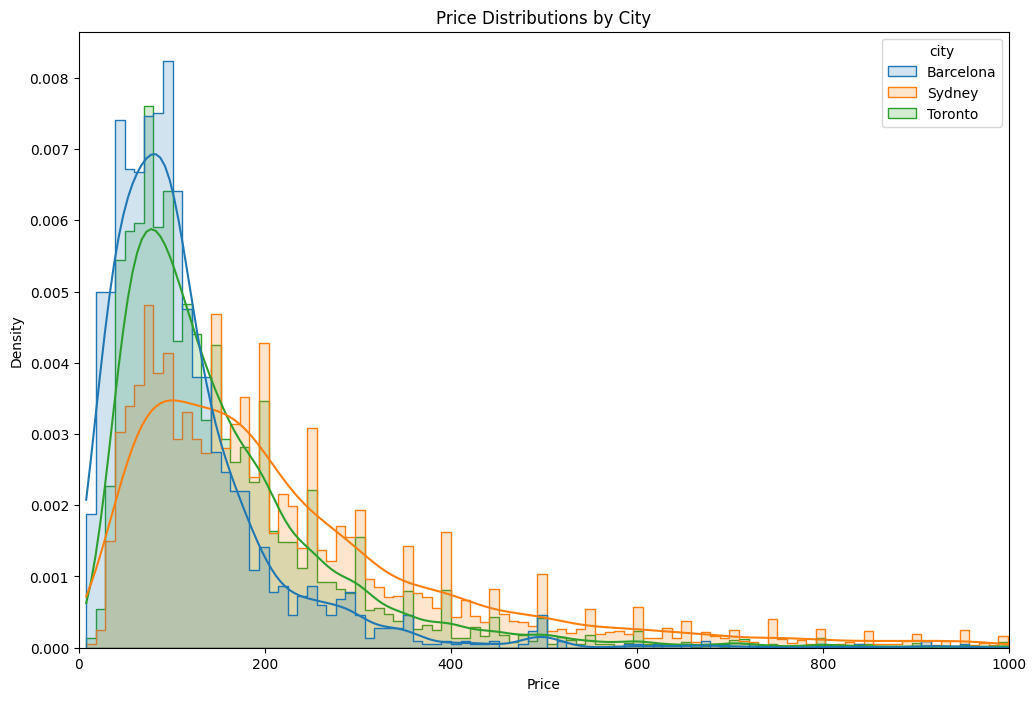

In [ ]:
# 3 charts – price distributions by city (sns.histplot)
import seaborn as sns
import matplotlib.pyplot as plt

# Looking at <$1000
df['price'] = pd.to_numeric(df['price'].str.replace('[^0-9.]', '', regex=True), errors='coerce')
df_filtered = df[df['price'] < 1000]
plt.figure(figsize=(12, 8))
sns.histplot(data=df_filtered, x='price', hue='city', element='step', stat='density', common_norm=False, kde=True, alpha=0.2)
plt.title('Price Distributions by City')
plt.xlabel('Price')
plt.ylabel('Density')
plt.xlim(0, 1000)
plt.show()



In [ ]:
categorical_columns = df.select_dtypes(include=['object', 'category']).columns

# Loop through the list of categorical columns and print value counts for each
for column in categorical_columns:
    num_unique_values = df[column].nunique()
    print(f"Column '{column}' has {num_unique_values} unique categories:")
    print(df[column].value_counts())
    print("\n")  # Print a newline for better readability between columns

In [ ]:
# Reducing Multicollinearity and Encoding Categorical Variables

# Convert Shared half-bath and Private half-bath and half-bath to 0.5, extract number from bathrooms_text, and create an indicator for shared_bathroom
# Convert has_availability to 1/0 (from t/f)
# We can make city 1,2,3 because we will separate the dataset by city later

# 1. drop column last_scraped, # drop property_type, neighbourhood_cleansed
df = df.drop(columns=['last_scraped', 'property_type', 'neighbourhood_cleansed'])

# 2. One-hot encode 'room_type'
df = pd.get_dummies(df, columns=['room_type'], drop_first=False)

# 3. Process 'bathrooms_text'
# Create shared_bathroom indicator
df['shared_bathroom'] = df['bathrooms_text'].str.contains('shared').astype(int)

# Extract numeric value from 'bathrooms_text' and handle special cases
def extract_bathrooms(text):
    if pd.isnull(text):
        return np.nan
    if 'half-bath' in text.lower():
        return 0.5
    numbers = pd.to_numeric(pd.Series(text).str.extract('(\d+\.?\d*)')[0], errors='coerce')
    if numbers.empty:
        return np.nan
    return numbers.iloc[0]

# Apply the corrected function
df['bathrooms'] = df['bathrooms_text'].apply(extract_bathrooms)

# Ensure we handle any potential issues with NaN values correctly
df['bathrooms'] = pd.to_numeric(df['bathrooms'], errors='coerce')

# Continue with the rest of your preprocessing
df = df.drop(columns=['bathrooms_text'])

# 4. Convert 'has_availability'
df['has_availability'] = df['has_availability'].map({'t': 1, 'f': 0})

# 5. Encode 'city' with numeric identifiers (e.g., Toronto=1, Sydney=2, Barcelona=3)
city_mapping = {'Toronto': 1, 'Sydney': 2, 'Barcelona': 3}
df['city_id'] = df['city'].map(city_mapping)
print(df.head())


In [ ]:
file_path = '/content/attractions-merged.csv'
df_attractions = pd.read_csv(file_path)
print(df_attractions.head)

<bound method NDFrame.head of        City                         Name  Num Reviews   Latitude   Longitude
0   Toronto                     CN Tower        25516  43.642564  -79.387087
1   Toronto          Toronto Island Park         8567  43.622545  -79.374706
2   Toronto          St. Lawrence Market        13998  43.648739  -79.371575
3   Toronto  Ripley's Aquarium of Canada        20709  43.642484  -79.386127
4   Toronto         Royal Ontario Museum         8476  43.667656  -79.394699
..      ...                          ...          ...        ...         ...
66   Sydney         WILD LIFE Sydney Zoo         1992 -33.869596  151.201634
67   Sydney       Madame Tussauds Sydney         1818 -33.869725  151.201655
68   Sydney                 Vivid Sydney         1623 -33.929525  151.152816
69   Sydney               Paddy's Market         1508 -33.861059  151.071217
70   Sydney           Sydney Fish Market         2365 -33.873147  151.192555

[71 rows x 5 columns]>


In [ ]:
# df_clustering = df

In [ ]:
# from geopy.distance import great_circle
# import pandas as pd

# def find_closest_attraction(property_lat, property_lon):
#     min_distance = float('inf')
#     closest_attraction = None
#     for _, attraction in df_attractions.iterrows():
#         attraction_lat_lon = (attraction['Latitude'], attraction['Longitude'])
#         property_lat_lon = (property_lat, property_lon)
#         distance = great_circle(attraction_lat_lon, property_lat_lon).meters
#         if distance < min_distance:
#             min_distance = distance
#             closest_attraction = attraction['Name']
#     return closest_attraction

# df_clustering['Closest Attraction'] = df_clustering.apply(lambda x: find_closest_attraction(x['latitude'], x['longitude']), axis=1)

In [ ]:
# df_clustering.head()

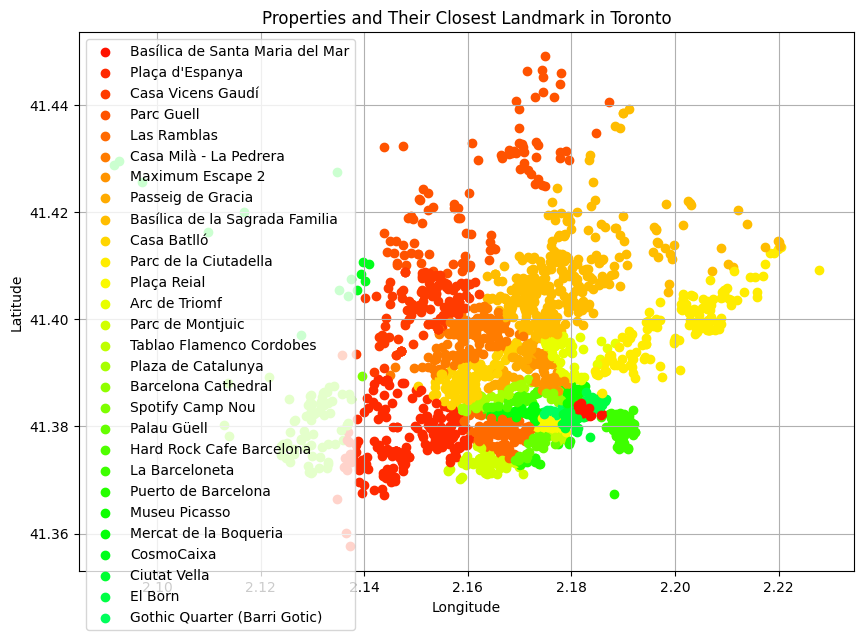

KeyboardInterrupt: 

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Assuming 'closest_attraction' is the column with the closest landmark name
# # and 'City' column exists with city names

# # Assign colors to each landmark
# landmarks = df_clustering['Closest Attraction'].unique()
# colors = sns.color_palette("hsv", len(landmarks))
# landmark_color_map = dict(zip(landmarks, colors))

# # Apply the color mapping
# df_clustering['Color'] = df_clustering['Closest Attraction'].map(landmark_color_map)

# # Plotting function for each city
# def plot_city_properties(city_name):
#     city_data = df_clustering[df_clustering['City'] == city_name]
#     plt.figure(figsize=(10, 7))
#     for _, row in city_data.iterrows():
#         plt.scatter(row['longitude'], row['latitude'], color=row['Color'], label=row['Closest Attraction'])

#     # Handling legends with unique entries
#     handles, labels = plt.gca().get_legend_handles_labels()
#     by_label = dict(zip(labels, handles))
#     plt.legend(by_label.values(), by_label.keys())

#     plt.title(f'Properties and Their Closest Landmark in {city_name}')
#     plt.xlabel('Longitude')
#     plt.ylabel('Latitude')
#     plt.grid(True)
#     plt.show()

# plot_city_properties('Toronto')
# plot_city_properties('Sydney')
# plot_city_properties('Barcelona')

<ipython-input-158-79579dd8e29f>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


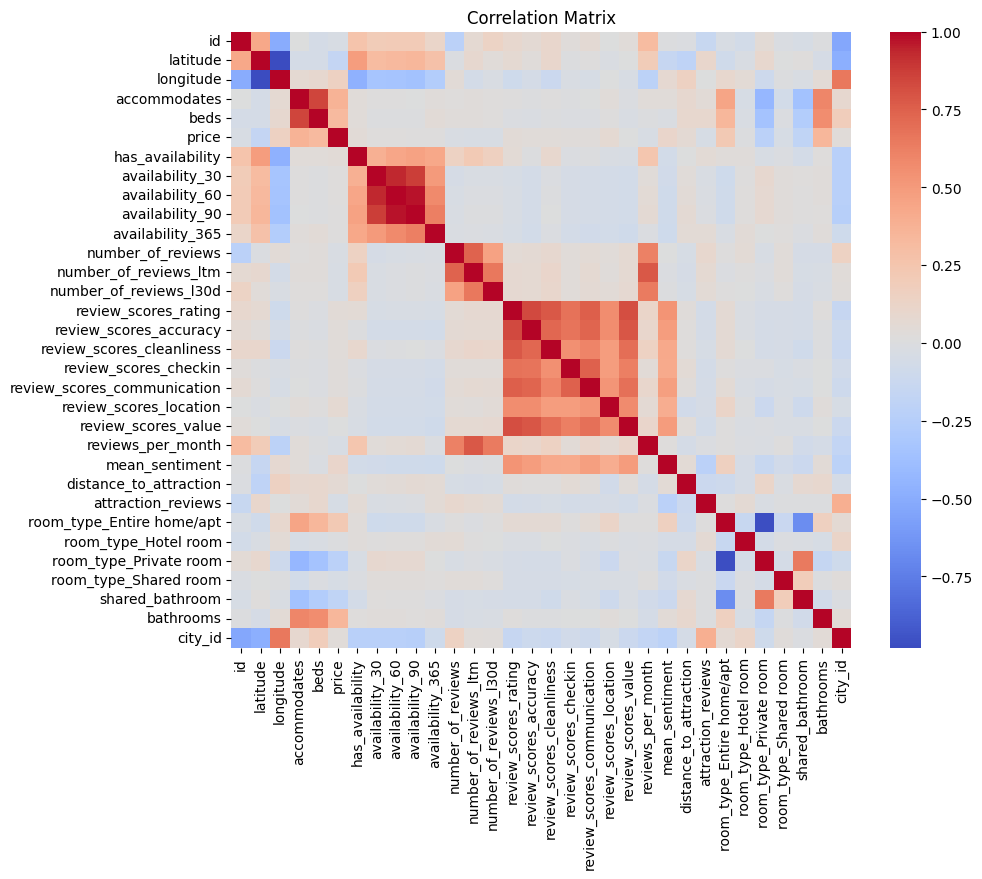

In [ ]:
#  Reduce multicollinearity (if necessary)
corr_matrix = df.corr()

# Display the correlation matrix
# print(corr_matrix)

# Optionally, you can visualize the correlation matrix using seaborn's heatmap for better readability
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
df.head()

,id,latitude,longitude,accommodates,beds,price,has_availability,availability_30,availability_60,availability_90,...,city,distance_to_attraction,attraction_reviews,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,shared_bathroom,bathrooms,city_id
0,24238187,41.382200,2.183750,3,3.0,$100.00,1,9,25,52,...,Barcelona,0.228118,13969.0,0,1,0,0,0,1.0,3
1,24238588,41.382200,2.183750,2,2.0,$75.00,1,14,34,62,...,Barcelona,0.228118,13969.0,0,1,0,0,0,1.0,3
2,24239102,41.375350,2.146050,4,3.0,$103.00,1,3,20,29,...,Barcelona,0.283139,5585.0,1,0,0,0,0,1.0,3
4,24257237,41.404880,2.153920,2,1.0,$73.00,1,27,57,76,...,Barcelona,0.314409,2417.0,1,0,0,0,0,1.0,3
5,24274447,41.416178,2.159658,2,1.0,$30.00,1,15,45,75,...,Barcelona,0.638132,77398.0,0,0,1,0,1,1.0,3


In [ ]:
# Split into 6 datasets: by city: Toronto, Barcelona, Sydney – objective and all columns
# Columns for the 'objective' dataset
df = df.drop(columns=['city'])
df['price'] = df['price'].str.replace('[^0-9.]', '', regex=True).astype('float64')
df_toronto_all = df[df['city_id'] == 1]
df_sydney_all = df[df['city_id'] == 2]
df_barcelona_all = df[df['city_id'] == 3]



In [ ]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import pandas as pd

def run_linear_regression(df, predictors, target='price', normalize=False, dataset_name='Dataset'):
    # Check for missing columns
    missing_columns = [col for col in predictors + [target] if col not in df.columns]
    if missing_columns:
        raise ValueError(f"The following columns are missing from the DataFrame: {missing_columns}")

    # Prepare predictors and target variables
    X = df[predictors]
    y = df[target]

    # Normalize features if requested
    if normalize:
        scaler = StandardScaler()
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

    # Add a constant to the model (intercept)
    X = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(y, X).fit()

    # Find significant predictors
    significant_predictors = model.pvalues[model.pvalues < 0.05].index.tolist()
    significant_coefs = model.params[significant_predictors]

    # Print results
    print(f"\nModel Summary for {dataset_name}:")
    # print(model.summary())
    print("\nSignificant predictors and their coefficients:")
    for predictor in significant_coefs.index:
        print(f"{predictor}: {significant_coefs[predictor]:.4f}")

    return model


In [ ]:
objective_columns = [
    'id', 'latitude', 'longitude', 'accommodates', 'beds',
    'has_availability', 'availability_30', 'availability_60', 'availability_90',
    'availability_365', 'distance_to_attraction',
    'room_type_Entire home/apt', 'room_type_Hotel room',
    'room_type_Private room', 'room_type_Shared room',
    'shared_bathroom', 'bathrooms', 'city_id'
]

all_columns = ['id', 'latitude', 'longitude', 'accommodates', 'beds', 'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 'mean_sentiment', 'distance_to_attraction', 'attraction_reviews', 'room_type_Entire home/apt', 'room_type_Hotel room', 'room_type_Private room', 'room_type_Shared room', 'shared_bathroom', 'bathrooms', 'city_id']


In [ ]:
all_columns = df.drop(['price'], axis=1).columns.tolist()  # Exclude 'price' from predictors

# Example calls for each dataset with 'all' columns
run_linear_regression(df_toronto_all, all_columns, normalize=True, dataset_name='Toronto All')
run_linear_regression(df_sydney_all, all_columns, normalize=True, dataset_name='Sydney All')
run_linear_regression(df_barcelona_all, all_columns, normalize=True, dataset_name='Barcelona All')

# Assuming 'objective_columns' is defined elsewhere and excludes 'price'
run_linear_regression(df_toronto_all, objective_columns, normalize=True, dataset_name='Toronto Objective')
run_linear_regression(df_sydney_all, objective_columns, normalize=True, dataset_name='Sydney Objective')
run_linear_regression(df_barcelona_all, objective_columns, normalize=True, dataset_name='Barcelona Objective')



Model Summary for Toronto All:

Significant predictors and their coefficients:
const: 175.2955
accommodates: 37.6379
beds: 13.1264
availability_30: 32.6662
availability_365: -7.0391
number_of_reviews_l30d: -16.4392
distance_to_attraction: -26.5823
room_type_Entire home/apt: 10.4099
room_type_Hotel room: -0.0000
room_type_Private room: -9.9875
shared_bathroom: -9.4344
bathrooms: 34.5897

Model Summary for Sydney All:

Significant predictors and their coefficients:
const: 283.5767
id: 19.1144
latitude: 10.8489
longitude: 95.6611
accommodates: 87.3270
has_availability: 37.6817
availability_365: 19.2701
review_scores_rating: 36.9374
review_scores_location: 11.3111
review_scores_value: -34.8488
distance_to_attraction: 33.5646
attraction_reviews: -17.3766
shared_bathroom: -14.9018
bathrooms: 115.8913

Model Summary for Barcelona All:

Significant predictors and their coefficients:
const: 122.9364
accommodates: 40.7328
availability_365: -17.4939
room_type_Entire home/apt: -15.1175
room_type_

In [ ]:
# Useful visualizations and Exploration - Robbie
# Comparing cities

In [ ]:
import plotly.express as px
df = pd.read_csv('airbnb_attractions.csv')
df['price'] = df['price'].str.replace('$', '')
df['price'] = df['price'].str.replace(',', '')
df['price'] = df['price'].astype(float)

num_prices = len(df)
df['price_rank'] = range(num_prices)
max_rank = df['price_rank'].max()
df['normalized_price_rank'] = (df['price_rank'] / max_rank) * 10

# a lot of the ratings are around 4-5 stars, which can make it difficult to vizualize, so the ratings were normalized to get a better sense of the differences
num_rating = len(df)
df['review_scores_rating'] = range(num_prices)
max_rank = df['review_scores_rating'].max()
df['normalized_rating'] = (df['review_scores_rating'] / max_rank) * 10

<ipython-input-25-9adfb4c259ef>:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('airbnb_attractions.csv')
<ipython-input-25-9adfb4c259ef>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df['price'].str.replace('$', '')


In [ ]:
# Create datasets for each city to properly vizualize it
barcelona_dataset = df[df['city'] == 'Barcelona']
sydney_dataset = df[df['city'] == 'Sydney']
toronto_dataset = df[df['city'] == 'Toronto']

In [ ]:
# New datasets were created to vizualize whether proximity to attraction can impact ratings
close_barcelona_dataset = barcelona_dataset[barcelona_dataset['distance_to_attraction'] < 0.5]
close_sydney_dataset = sydney_dataset[sydney_dataset['distance_to_attraction'] < 0.5]
close_toronto_dataset = toronto_dataset[toronto_dataset['distance_to_attraction'] < 0.5]
far_barcelona_dataset = barcelona_dataset[barcelona_dataset['distance_to_attraction'] > 0.5]
far_sydney_dataset = sydney_dataset[sydney_dataset['distance_to_attraction'] > 0.5]
far_toronto_dataset = toronto_dataset[toronto_dataset['distance_to_attraction'] > 0.5]


In [ ]:
px.scatter_mapbox(close_barcelona_dataset, lon="longitude", lat="latitude", color="normalized_rating", color_continuous_scale='Viridis', mapbox_style='carto-darkmatter', zoom=11, title="Review Scores in Barcelona")

In [ ]:
px.scatter_mapbox(far_barcelona_dataset, lon="longitude", lat="latitude", color="normalized_rating", color_continuous_scale='Viridis', mapbox_style='carto-darkmatter', zoom=11, title="Review Scores in Barcelona")

In [ ]:
px.scatter_mapbox(close_sydney_dataset, lon="longitude", lat="latitude", color="normalized_rating", color_continuous_scale='Viridis', mapbox_style='carto-darkmatter', zoom=11, title="Review Scores in Sydney")

In [ ]:
px.scatter_mapbox(far_sydney_dataset, lon="longitude", lat="latitude", color="normalized_rating", mapbox_style='carto-darkmatter', color_continuous_scale='Viridis', zoom=9, title="Review Scores in Sydney")

In [ ]:
px.scatter_mapbox(close_toronto_dataset, lon="longitude", lat="latitude", color="normalized_rating", mapbox_style='carto-darkmatter', color_continuous_scale='Viridis', zoom=11, title="Review Scores in Toronto")

In [ ]:
px.scatter_mapbox(far_toronto_dataset, lon="longitude", lat="latitude", color="normalized_rating", mapbox_style='carto-darkmatter', color_continuous_scale='Viridis', zoom=11, title="Review Scores in Toronto")

Number of Reviews

In [ ]:
px.scatter_mapbox(barcelona_dataset, lon="longitude", lat="latitude", color="attraction_reviews", color_continuous_scale='Viridis', mapbox_style='carto-darkmatter', zoom=12, title="Number of Reviews for Closest Landmark in Barcelona")

In [ ]:
px.scatter_mapbox(toronto_dataset, lon="longitude", lat="latitude", color="attraction_reviews", color_continuous_scale='Viridis', mapbox_style='carto-darkmatter', zoom=12, title="Number of Reviews for Closest Landmark in Sydney")

In [ ]:
px.scatter_mapbox(sydney_dataset, lon="longitude", lat="latitude", color="attraction_reviews", color_continuous_scale='Viridis', mapbox_style='carto-darkmatter', zoom=12, title="Number of Reviews for Closest Landmark in Toronto")

Price

In [ ]:
px.scatter_mapbox(barcelona_dataset, lon="longitude", lat="latitude", color="normalized_price_rank", color_continuous_scale='Viridis', mapbox_style='carto-darkmatter', zoom=12, title="Price of Airbnbs in Barcelona")

In [ ]:
px.scatter_mapbox(toronto_dataset, lon="longitude", lat="latitude", color="normalized_price_rank", color_continuous_scale='Viridis', mapbox_style='carto-darkmatter', zoom=12, title="Price of Airbnbs in Sydney")

In [ ]:
px.scatter_mapbox(toronto_dataset, lon="longitude", lat="latitude", color="normalized_price_rank", color_continuous_scale='Viridis', mapbox_style='carto-darkmatter', zoom=12, title="Price of Airbnbs in Toronto")

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import splot
from shapely.geometry import Point, Polygon

from esda.moran import Moran
from splot.esda import moran_scatterplot
from esda.moran import Moran_Local
from splot.esda import plot_moran
from splot.esda import lisa_cluster
from splot.esda import plot_local_autocorrelation

# Hypothesis testing - Huy
def get_data_frame(city: str):  # Will have to be changed for Colab
    link_to_data = f"./shp_file/neighbourhoods_{city.title()}-polygon.shp"
    gdf = gpd.read_file(link_to_data)
    attract_df = pd.read_csv("./attractions-merged.csv")
    airbnb_df = pd.read_csv("./airbnb_attractions.csv")
    return gdf, attract_df, airbnb_df

def plot_listings_and_attractions(gdf, attract_df, airbnb_df, city):
    # Get the neighbourhoods
    neighbor = gdf["neighbourh"].unique()
    neighbor_group = gdf["neighbou_1"].unique()
    # Some city may have no neighbor group at all and that can lead to None results when looking for rows
    # containing data in a specific city!
    if neighbor_group[0] is not None:
        city_listings = airbnb_df.loc[airbnb_df["neighbourhood_cleansed"].isin(neighbor) &
    airbnb_df["neighbourhood_group_cleansed"].isin(neighbor_group)]
    else:
        city_listings = airbnb_df.loc[airbnb_df["neighbourhood_cleansed"].isin(neighbor)]
    city_attractions = attract_df.loc[attract_df["City"]==f"{city.title()}"]

    # Compute the average of the distance_to_nearest_attraction in each neighborhood
    gdf["avg_nearest_dist_attr"] = [0.0 for i in range(gdf.shape[0])]
    for i in range(gdf.shape[0]):
        # Get the neighbor. I don't care about efficiency for this part.
        cur_neighbor = gdf.loc[i, "neighbourh"]
        neighbor_listings = city_listings.loc[city_listings["neighbourhood_cleansed"]==cur_neighbor]
        # average for each neighborhood zone.
        gdf.loc[i, "avg_nearest_dist_attr"] = neighbor_listings["distance_to_attraction"].mean()
        gdf.loc[i, "num_listings"] = neighbor_listings.shape[0]
    # Standardized 1/distance * num_listings as weight
    gdf["weighed_standardized"] = 1/gdf["avg_nearest_dist_attr"] * gdf["num_listings"]
    gdf["weighed_standardized"] = (gdf["weighed_standardized"] - gdf["weighed_standardized"].mean()) / gdf["weighed_standardized"].std()

    # Create Points using Longitude and Latitude
    listings_geometry = [Point(xy) for xy in zip(city_listings["longitude"], city_listings["latitude"])]
    attractions_geometry = [Point(xy) for xy in zip(city_attractions["Longitude"], city_attractions["Latitude"])]
    # ORDER OF ZIP MATTERS!!!

    # Create the GeoDataFrame
    crs = {'init':'epsg:4326'}  # May be wrong tho for our case.....
    listings_gdf = gpd.GeoDataFrame(city_listings, #specify our data
                              crs=crs, #specify our coordinate reference system
                              geometry=listings_geometry) #specify the geometry list we created
    attractions_gdf = gpd.GeoDataFrame(attractions_geometry, #specify our data
                              crs=crs, #specify our coordinate reference system
                              geometry=attractions_geometry) #specify the geometry list we created

    # Plot the listings point and the attractions positions
    fig, ax = plt.subplots(figsize=(15,15))
    gdf.plot(ax=ax, color="grey")
    listings_gdf.plot(ax=ax, markersize=20, color='red', marker='o', label="Listings")
    attractions_gdf.plot(ax=ax, markersize=20, color='purple', marker='^', label="Attractions")
    plt.legend(prop={'size':15})
    # plt.savefig(f"{city}_scatter.png")

In [ ]:
def moran_landmark_distance(gdf, has_island):
    # Output both Global Moran and Local Moran (Both Univariate)
    # Make sure gdf has the  attribute weighed_standardized created in plot_listings_and_attractions function!
    # Right now...Remove the neighbors with no listings....
    neighbor_with_listings = gdf
    # Remove islands...Experimental
    if has_island:
        indices = neighbor_with_listings.index.tolist()
        for i in indices:
            L = []
            island = True
            for j in indices:
                if i != j:
                  L.append(neighbor_with_listings.iloc[i].geometry.distance(neighbor_with_listings.iloc[j].geometry))
            for k in range(len(L)):
                if abs(L[k]) <= 10e-5:
                    neighbor_with_listings.at[i,'island'] = 1
                    island = False
                    break
            if island:
                neighbor_with_listings.at[i,'island']=0
        neighbor_with_listings = neighbor_with_listings[neighbor_with_listings["island"] == 1]
    neighbor_with_listings = neighbor_with_listings.dropna(subset=["avg_nearest_dist_attr"])

    y = neighbor_with_listings["weighed_standardized"].values
    w = Queen.from_dataframe(neighbor_with_listings)
    moran = Moran(y, w)
    moran_stats = moran.I
    print(moran_stats, moran.p_sim)
    # plot_moran(moran, zstandard=True, figsize=(10,4))
    # LISA time
    moran_loc = Moran_Local(y, w, permutations=2000)
    # We finna draw LISA clusters manually now.
    neighbor_with_listings['significant'] = moran_loc.p_sim < 0.05
    neighbor_with_listings['quadrant'] = moran_loc.q
    # Left Outer Join....for some reasons....
    gdf_renewed = pd.merge(gdf, neighbor_with_listings, on=["neighbourh", "neighbou_1", "geometry"], how='left')
    # ok, the join works
    f, ax = plt.subplots(1, figsize=(15, 15))
    # Plot the city shapefile
    gdf_renewed.plot(ax=ax, color="grey")
    # Plot the HH clusters
    hh = gdf_renewed.loc[(gdf_renewed["quadrant"]==1) & (gdf_renewed["significant"]==True), "geometry"]
    if hh.shape[0] != 0:
        hh.plot(ax=ax, color="blue", label="HH Cluster")
    # Plot the LL clusters
    ll = gdf_renewed.loc[(gdf_renewed["quadrant"]==3) & (gdf_renewed["significant"]==True), "geometry"]
    if ll.shape[0] != 0:
        ll.plot(ax=ax, color="red", label="LL Cluster")
    # Plot the LH clusters
    lh = gdf_renewed.loc[(gdf_renewed["quadrant"]==2) & (gdf_renewed["significant"]==True), "geometry"]
    if lh.shape[0] != 0:
        lh.plot(ax=ax, color="orange", label="LH Cluster")
    hl = gdf_renewed.loc[(gdf_renewed["quadrant"]==4) & (gdf_renewed["significant"]==True), "geometry"]
    if hl.shape[0] != 0:
        hl.plot(ax=ax, color="magenta", label="HL Cluster")
    # Manual legend
    legend_elements = [Patch(facecolor="blue", edgecolor="blue", label="HH Cluster"),
                       Patch(facecolor="red", edgecolor="red", label="LL Cluster"),
                       Patch(facecolor="orange", edgecolor="orange", label="LH Cluster"),
                       Patch(facecolor="magenta", edgecolor="magenta", label="HL Cluster"),
                       Patch(facecolor="grey", edgecolor="grey", label="Not Significant")]
    ax.legend(handles=legend_elements)
    # plt.savefig(f"{city[0]}_LISA.png")

In [ ]:
# Test with Barcelona. Format: (<city_name>, has_island).
cities = [("Barcelona", True), ("Toronto", False), ("Sydney", False)]
for city in cities:
    name, has_island = city
    print(f"City: {name.title()}")
    city_gdf, city_attract_df, airbnb_df = get_data_frame(name)
    plot_listings_and_attractions(city_gdf, city_attract_df, airbnb_df, name)
    moran_landmark_distance(city_gdf, has_island)
    print("")

# Deep Learning CNN - Kunyan

In [4]:
df = pd.read_csv('/content/airbnb_attractions.csv')
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
# Fill NA values in the 'price' column with the mean of the 'price' column
df['price'].fillna(df['price'].mean(), inplace=True)

<ipython-input-4-8c709c47a4ed>:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/airbnb_attractions.csv')


In [5]:
df = df.drop(columns=['last_scraped','id', 'city','neighbourhood',
 'neighbourhood_cleansed', 'bathrooms',
 'neighbourhood_group_cleansed','property_type','bathrooms_text',
 'bedrooms','room_type','has_availability'])
df.fillna(df.mean(), inplace=True)
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df

,latitude,longitude,accommodates,beds,price,availability_30,availability_60,availability_90,availability_365,number_of_reviews,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,mean_sentiment,distance_to_attraction,attraction_reviews
0,41.382200,2.183750,3,3.0,100.000000,9,25,52,97,65,...,4.80,4.82,4.86,4.82,4.89,4.65,1.11,0.576770,0.228118,13969.0
1,41.382200,2.183750,2,2.0,75.000000,14,34,62,113,412,...,4.72,4.75,4.81,4.85,4.89,4.59,6.24,0.685170,0.228118,13969.0
2,41.375350,2.146050,4,3.0,103.000000,3,20,29,29,199,...,4.93,4.86,4.97,4.96,4.88,4.75,3.03,0.683130,0.283139,5585.0
3,41.381580,2.177120,2,1.0,210.531978,0,0,0,0,14,...,4.64,3.93,4.57,4.43,4.86,4.07,0.21,0.655540,0.202531,40468.0
4,41.404880,2.153920,2,1.0,73.000000,27,57,76,76,10,...,4.70,4.50,4.90,5.00,5.00,4.80,0.19,0.482480,0.314409,2417.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22300,43.693860,-79.314360,4,2.0,150.000000,0,0,0,0,2,...,5.00,5.00,5.00,5.00,5.00,4.67,0.45,0.455800,3.125711,1778.0
22301,43.671400,-79.394910,2,1.0,125.000000,0,0,0,0,141,...,4.86,4.85,4.75,4.93,4.90,4.76,3.33,0.881030,0.416605,8476.0
22302,43.647399,-79.422803,6,5.0,89.000000,0,0,0,0,7,...,5.00,4.88,4.88,5.00,5.00,5.00,1.81,0.620186,1.867270,2974.0
22303,43.640223,-79.395951,6,3.0,198.000000,0,0,0,0,36,...,4.51,4.65,4.51,4.54,4.73,4.32,5.05,0.514460,0.566434,3999.0


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda


In [7]:
y = df['price'].replace('[\$,]', '', regex=True).astype(float)

In [8]:
max(df['distance_to_attraction'])

53.65196188714963

In [9]:

model = Sequential()

# Select features and target variable
X = df.drop(columns=['price'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')



In [10]:
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

# Calculate the mean of the 'price' column
price_mean = df['price'].mean()

# Fill NA values in 'price' column with the calculated mean
df['price'] = df['price'].fillna(price_mean)

# Now when you assign the 'price' column to y_train, it should not contain any NAs
y_train = df['price']

# If you print y_train, it should no longer have any NaN values
print(y_train)

0        100.000000
1         75.000000
2        103.000000
3        210.531978
4         73.000000
            ...    
22300    150.000000
22301    125.000000
22302     89.000000
22303    198.000000
22304    200.000000
Name: price, Length: 22305, dtype: float64


In [11]:

# Define the learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True)

# Set up the optimizer with the learning rate schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer=optimizer,
              loss='mse',
              metrics=['mae', 'mse'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)

# Evaluate the model
loss, mae, mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Abs Error on Test Set: {mae}")
print(f"Mean Sq Error on Test Set: {mse}")


Mean Abs Error on Test Set: 137.49974060058594
Mean Sq Error on Test Set: 99800.59375


In [14]:
y_pred = model.predict(X_test)

140/140 [==============================] - 0s 2ms/step


In [12]:
rmse = np.sqrt(mse)
rmse

315.91231971862067

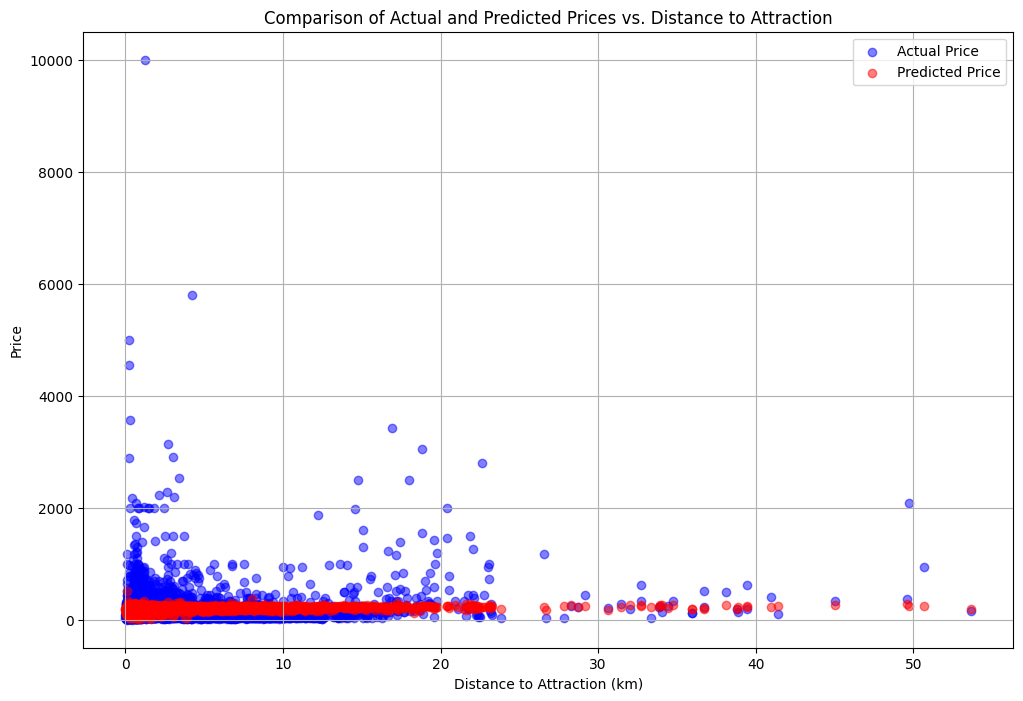

In [15]:
distance_to_attraction = X_test['distance_to_attraction']

# Create a figure and axis
plt.figure(figsize=(12, 8))

# Scatter plot for actual prices vs distance to attraction
plt.scatter(distance_to_attraction, y_test, alpha=0.5, color='blue', label='Actual Price')

# Scatter plot for predicted prices vs distance to attraction
plt.scatter(distance_to_attraction, y_pred, alpha=0.5, color='red', label='Predicted Price')

# Adding plot title and labels
plt.title('Comparison of Actual and Predicted Prices vs. Distance to Attraction')
plt.xlabel('Distance to Attraction (km)')
plt.ylabel('Price')
plt.legend()

# Show grid
plt.grid(True)

# Show the plot
plt.show()

Random Forest

In [ ]:
df = pd.read_csv('/content/airbnb_attractions.csv')
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

# Fill NA values in the 'price' column with the mean of the 'price' column
df['price'].fillna(df['price'].mean(), inplace=True)

<ipython-input-19-e00248e1df21>:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/airbnb_attractions.csv')


In [ ]:
df = df.drop(columns=['last_scraped','id', 'city','neighbourhood',
 'neighbourhood_cleansed', 'bathrooms',
 'neighbourhood_group_cleansed','property_type','bathrooms_text',
 'bedrooms','room_type','has_availability'])

df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df

,latitude,longitude,accommodates,beds,price,availability_30,availability_60,availability_90,availability_365,number_of_reviews,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,mean_sentiment,distance_to_attraction,attraction_reviews
0,41.382200,2.183750,3,3.0,100.000000,9,25,52,97,65,...,4.80,4.82,4.86,4.82,4.89,4.65,1.11,0.576770,0.228118,13969.0
1,41.382200,2.183750,2,2.0,75.000000,14,34,62,113,412,...,4.72,4.75,4.81,4.85,4.89,4.59,6.24,0.685170,0.228118,13969.0
2,41.375350,2.146050,4,3.0,103.000000,3,20,29,29,199,...,4.93,4.86,4.97,4.96,4.88,4.75,3.03,0.683130,0.283139,5585.0
3,41.381580,2.177120,2,1.0,210.531978,0,0,0,0,14,...,4.64,3.93,4.57,4.43,4.86,4.07,0.21,0.655540,0.202531,40468.0
4,41.404880,2.153920,2,1.0,73.000000,27,57,76,76,10,...,4.70,4.50,4.90,5.00,5.00,4.80,0.19,0.482480,0.314409,2417.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22300,43.693860,-79.314360,4,2.0,150.000000,0,0,0,0,2,...,5.00,5.00,5.00,5.00,5.00,4.67,0.45,0.455800,3.125711,1778.0
22301,43.671400,-79.394910,2,1.0,125.000000,0,0,0,0,141,...,4.86,4.85,4.75,4.93,4.90,4.76,3.33,0.881030,0.416605,8476.0
22302,43.647399,-79.422803,6,5.0,89.000000,0,0,0,0,7,...,5.00,4.88,4.88,5.00,5.00,5.00,1.81,0.620186,1.867270,2974.0
22303,43.640223,-79.395951,6,3.0,198.000000,0,0,0,0,36,...,4.51,4.65,4.51,4.54,4.73,4.32,5.05,0.514460,0.566434,3999.0


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import numpy as np

for col in df.select_dtypes(include=np.number).columns:
    df[col].fillna(df[col].median(), inplace=True)
# Encode categorical variables
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Split the data into features and target
X = df.drop('price', axis=1)  # Assuming 'price' is the column to predict
y = df['price']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 270.23945207600923


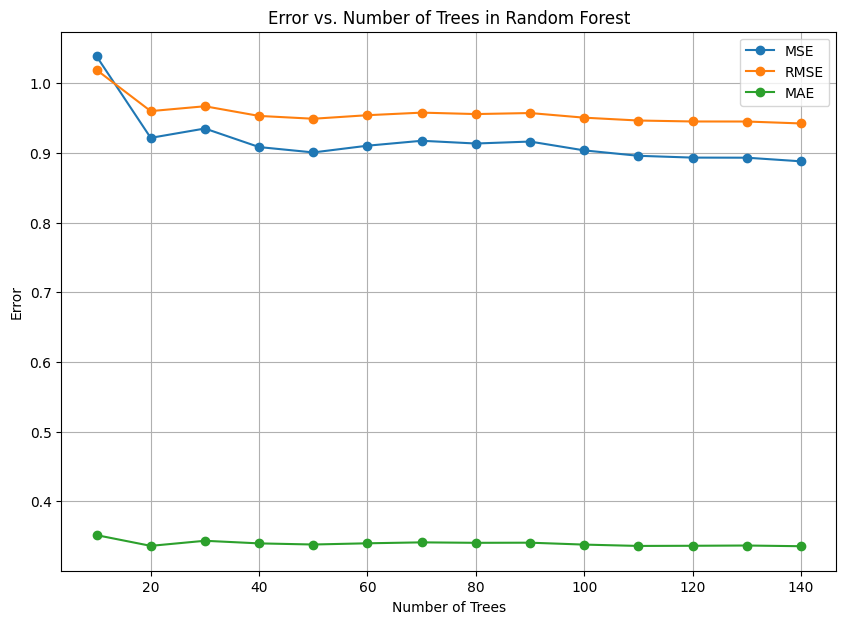

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define the features and target variable
X = df.drop('price', axis=1)
y = df['price']

# Define a range of trees to evaluate
trees_range = range(10, 150, 10)

# Initialize lists to store errors for each tree count
mse_scores = []
rmse_scores = []
mae_scores = []

# Loop through the range of tree numbers
for trees in trees_range:
    model = RandomForestRegressor(n_estimators=trees, random_state=42)
    # Using negative mean squared error to follow convention (higher is better)
    mse = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error').mean()
    rmse = np.sqrt(mse)
    mae = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error').mean()

    mse_scores.append(mse)
    rmse_scores.append(rmse)
    mae_scores.append(mae)

# Plotting the results
plt.figure(figsize=(10, 7))
plt.plot(trees_range, mse_scores, label='MSE', marker='o')
plt.plot(trees_range, rmse_scores, label='RMSE', marker='o')
plt.plot(trees_range, mae_scores, label='MAE', marker='o')
plt.xlabel('Number of Trees')
plt.ylabel('Error')
plt.title('Error vs. Number of Trees in Random Forest')
plt.legend()
plt.grid(True)
plt.show()


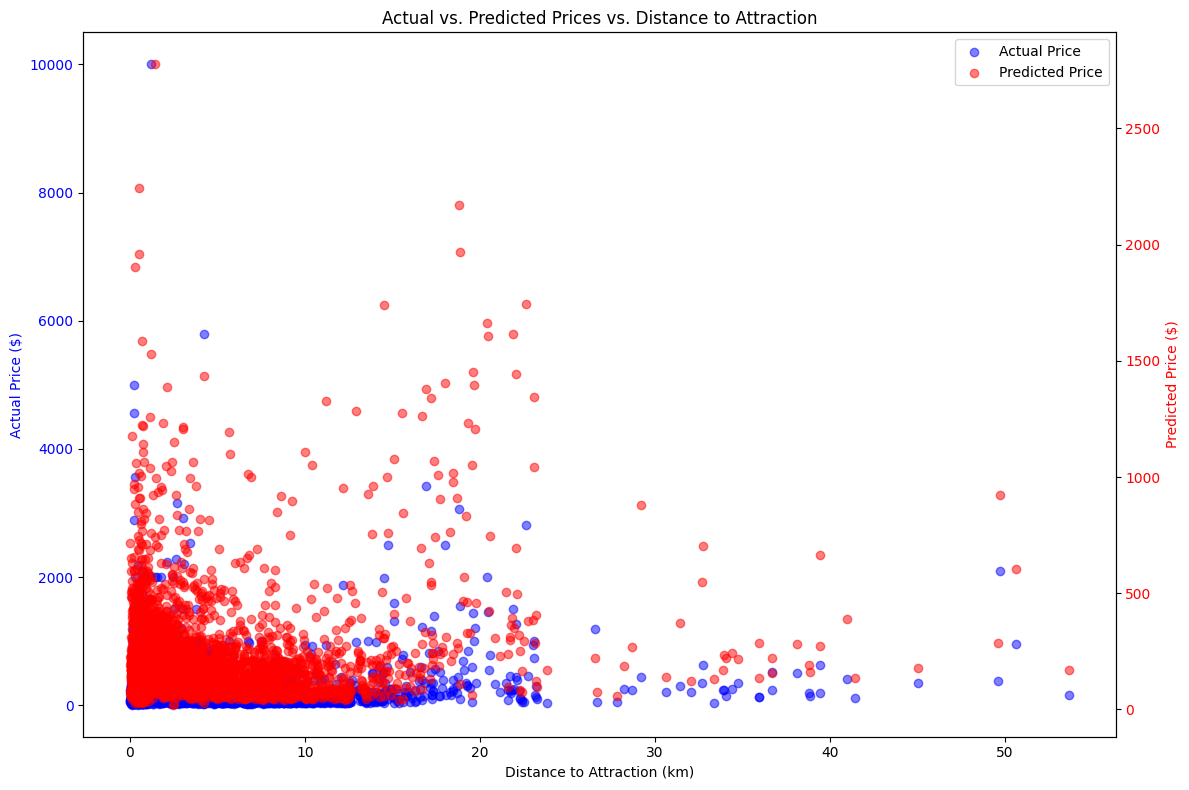

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Assuming 'distance_to_attraction' is in your DataFrame and was part of X_test
distance_to_attraction = X_test['distance_to_attraction']

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111)

# Scatter plot for actual prices
scatter1 = ax1.scatter(distance_to_attraction, y_test, color='blue', label='Actual Price', alpha=0.5)
ax1.set_xlabel('Distance to Attraction (km)')
ax1.set_ylabel('Actual Price ($)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for the predicted prices
ax2 = ax1.twinx()
scatter2 = ax2.scatter(distance_to_attraction, y_pred, color='red', label='Predicted Price', alpha=0.5)
ax2.set_ylabel('Predicted Price ($)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Title and legend
plt.title('Actual vs. Predicted Prices vs. Distance to Attraction')
fig.tight_layout()

# Legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# Show plot
plt.show()




KNN

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np

for col in df.select_dtypes(include=np.number).columns:
    df[col].fillna(df[col].median(), inplace=True)

# Feature scaling for KNN
scaler = StandardScaler()
df[df.columns] = scaler.fit_transform(df)

# Split the data into features and target
X = df.drop('price', axis=1)  # Assuming 'price' is the column to predict
y = df['price']

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Make predictions
y_pred = knn_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 0.9230294961967598


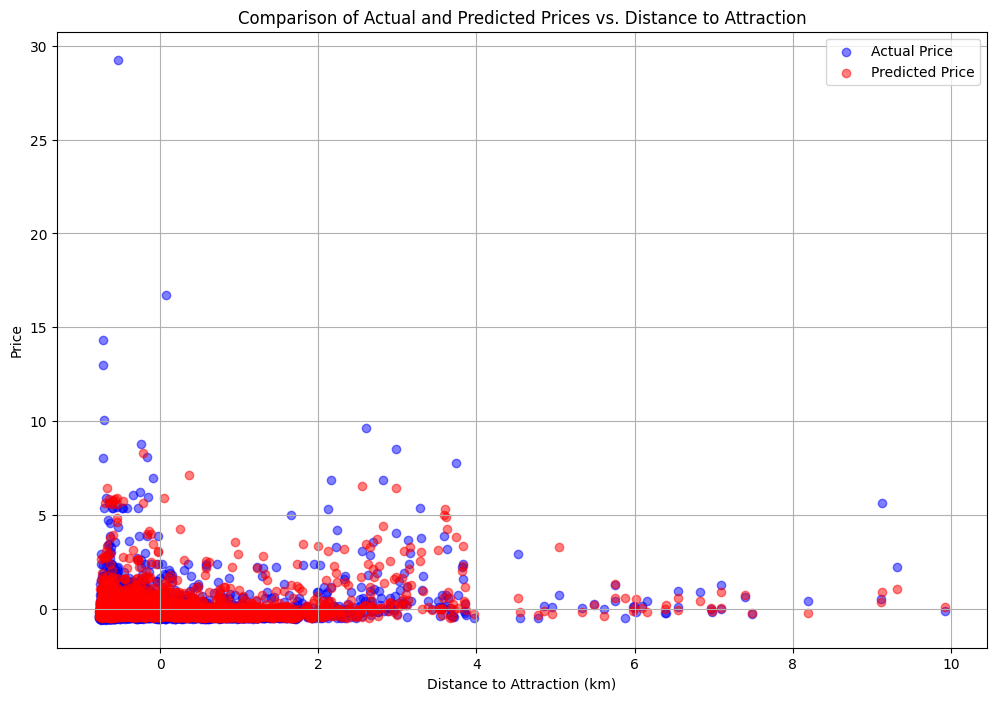

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'distance_to_attraction' is a column in your original dataframe
# Ensure this column is not included in X_train or X_test
distance_to_attraction = X_test['distance_to_attraction']  # Extract from X_test for corresponding predictions

# Create a plot
plt.figure(figsize=(12, 8))

# Plotting actual prices vs. distance to attraction
plt.scatter(distance_to_attraction, y_test, alpha=0.5, color='blue', label='Actual Price')
# Plotting predicted prices vs. distance to attraction
plt.scatter(distance_to_attraction, y_pred, alpha=0.5, color='red', label='Predicted Price')

# Adding plot title and labels
plt.title('Comparison of Actual and Predicted Prices vs. Distance to Attraction')
plt.xlabel('Distance to Attraction (km)')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


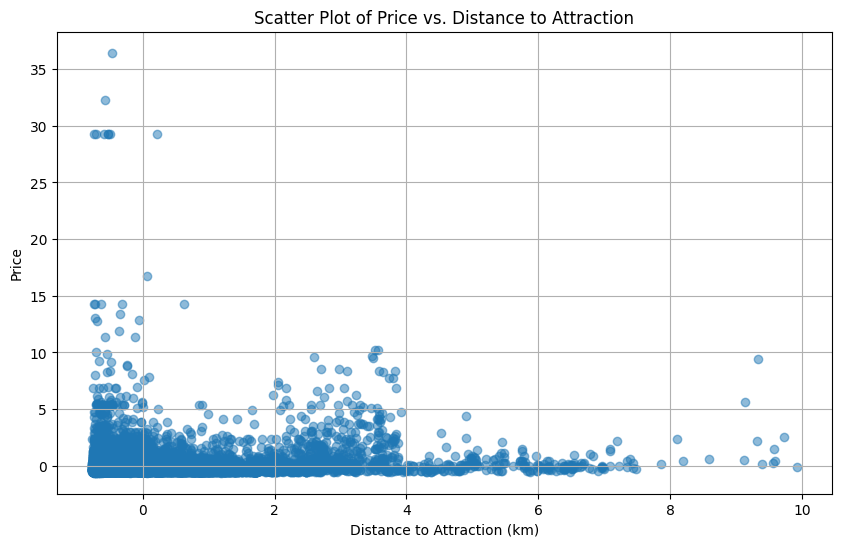

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'distance_to_attraction' and 'price' are columns in your original dataframe
# Ensure that you have these columns available in the dataframe

# Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(df['distance_to_attraction'], df['price'], alpha=0.5)
plt.title('Scatter Plot of Price vs. Distance to Attraction')
plt.xlabel('Distance to Attraction (km)')
plt.ylabel('Price')
plt.grid(True)
plt.show()

